### Imports

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from node2vec import Node2Vec

In [2]:
from medmodels.predictive_modeling.hsgnn.hsgnn_preprocessing import HSGNNPreprocessor
from medmodels.predictive_modeling.hsgnn.model_preprocessing import (compute_embeddings,
                                                                     compute_embeddings_mce)
from medmodels_dev.utils.mimic_helper import MimicHelper
from medmodels.predictive_modeling.hsgnn.train_hsgnn import train_hsgnn
from medmodels.predictive_modeling.hsgnn.hsgnn_model import HSGNNModel
from medmodels.predictive_modeling.hsgnn.predictions import HSGNNPredictor

### Load data

In [74]:
data_path = (
    "/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/medrecords/medrecord_5000_pats.dill")
medrecord = pickle.load(open(data_path, "rb"))

In [75]:
mce_model_path = (
    "/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/mce/models/100000pats_NoTranslate_New.pt"
)

In [3]:
mh = MimicHelper('/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/mimic-iv')

### HSGNN Preprocessing

In [4]:
hsgnn_preprocessor = HSGNNPreprocessor(medrecord)

In [10]:
graph_schema = hsgnn_preprocessor.create_graph_schema()
print(graph_schema, "\n", graph_schema.edges)

Graph with 5 nodes and 5 edges 
 [('patients', 'admissions'), ('patients', 'diagnoses'), ('patients', 'prescriptions'), ('patients', 'procedures'), ('admissions', 'diagnoses')]


In [16]:
meta_paths = hsgnn_preprocessor.find_metapaths()
print("Found ", len(meta_paths), "unique meta-paths of length 3:")
for i, meta_path in enumerate(meta_paths):
    print(i, ":", meta_path)

Found  18 unique meta-paths of length 3:
0 : ['patients', 'admissions', 'patients']
1 : ['patients', 'diagnoses', 'admissions']
2 : ['patients', 'admissions', 'diagnoses']
3 : ['patients', 'diagnoses', 'patients']
4 : ['patients', 'prescriptions', 'patients']
5 : ['patients', 'procedures', 'patients']
6 : ['admissions', 'patients', 'admissions']
7 : ['admissions', 'patients', 'diagnoses']
8 : ['admissions', 'diagnoses', 'admissions']
9 : ['admissions', 'patients', 'prescriptions']
10 : ['admissions', 'patients', 'procedures']
11 : ['diagnoses', 'patients', 'diagnoses']
12 : ['diagnoses', 'admissions', 'diagnoses']
13 : ['diagnoses', 'patients', 'prescriptions']
14 : ['diagnoses', 'patients', 'procedures']
15 : ['prescriptions', 'patients', 'prescriptions']
16 : ['prescriptions', 'patients', 'procedures']
17 : ['procedures', 'patients', 'procedures']


In [18]:
subgraphs = hsgnn_preprocessor.sym_sim_matrices("fast")

Computing similarity subgraphs:   0%|          | meta-path | 0/18 [00:00<?, ?it/s]/Users/anastasiia.tiurina/Desktop/projects/medmodels/src/medmodels/predictive_modeling/hsgnn/hsgnn_preprocessing.py:284: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  pc_matrix = nx.adjacency_matrix(self.medrecord.G, nodelist=nodelist)
/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/.venv/lib/python3.9/site-packages/scipy/sparse/_base.py:655: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
Computing similarity subgraphs: 100%|██████████| meta-path | 18/18 [00:06<00:00,  2.71it/s]


In [19]:
subgraphs

[tensor(indices=tensor([[  0,   0,   0,  ..., 999, 999, 999],
                        [  0,   1,   2,  ..., 997, 998, 999]]),
        values=tensor([1., 0., 0.,  ..., 0., 0., 1.]),
        size=(8617, 8617), nnz=1000000, dtype=torch.float16,
        layout=torch.sparse_coo),
 tensor(indices=tensor([[   0,    0,    0,  ..., 2425, 2425, 2425],
                        [1000, 1001, 1002,  ...,  997,  998,  999]]),
        values=tensor([0., 0., 0.,  ..., 0., 0., 0.]),
        size=(8617, 8617), nnz=2852000, dtype=torch.float16,
        layout=torch.sparse_coo),
 tensor(indices=tensor([[   0,    0,    0,  ..., 5523, 5523, 5523],
                        [2426, 2427, 2428,  ...,  997,  998,  999]]),
        values=tensor([0., 0., 0.,  ..., 0., 0., 0.]),
        size=(8617, 8617), nnz=6196000, dtype=torch.float16,
        layout=torch.sparse_coo),
 tensor(indices=tensor([[  0,   0,   0,  ..., 999, 999, 999],
                        [  0,   1,   2,  ..., 997, 998, 999]]),
        values=tensor(

### Compute embeddings

#### Embeddings with Node2Vec

In [7]:
node2vec_embeddings = compute_embeddings(medrecord, workers=4)

Computing transition probabilities:   0%|          | 0/1691 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


In [76]:
node2vec_model = Node2Vec(medrecord.G, dimensions=100, workers=4)
node2vec_model = node2vec_model.fit(window=10)
node2vec_embeddings = pd.DataFrame(
        [node2vec_model.wv.get_vector(str(n)) for n in medrecord.G.nodes()],
        index=medrecord.G.nodes,)

Computing transition probabilities:   0%|          | 0/24286 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [02:00<00:00, 60.37s/it]


In [85]:
sampled = node2vec_embeddings.sample(3)

In [82]:
def translate_node(node):
    if node in medrecord.dimension("diagnoses"):
        if mh.translate_diagnoses(10, node) != {}:
            translation = mh.translate_diagnoses(10, node)
        else:
            translation = mh.translate_diagnoses(9, node)
    elif node in medrecord.dimension("procedures"):
        translation = mh.translate_procedures(node)
    elif node in medrecord.dimension("prescriptions"):
        translation = mh.translate_prescriptions(node)
    else:
        translation = node
    return translation

In [83]:
def find_most_similar(node):
    most_similar = node2vec_model.wv.most_similar(node, topn=10)
    translated_node = translate_node(node)
    if node in medrecord.dimension("admissions") or node in medrecord.dimension("patients"):
      print("Diagnoses of ", translated_node, ":")
      for edge in medrecord.G.edges(node):
        if edge[1] not in medrecord.dimension("admissions") and edge[1] not in medrecord.dimension("patients"):
          print(node, edge[1], translate_node(edge[1]))
    print("Most similar to ", translated_node, ":")
    for i, prob in most_similar:
      print(i, translate_node(i), prob)

In [86]:
for node in sampled.index:
    find_most_similar(node)
    print("------------------")

Diagnoses of  29999480 :
29999480 V08 {'V08': 'Asymptomatic human immunodeficiency virus [HIV] infection status'}
29999480 07030 {'07030': 'Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta'}
29999480 78841 {'78841': 'Urinary frequency'}
29999480 V420 {'V420': 'Car driver injured in collision with two- or three-wheeled motor vehicle in nontraffic accident'}
29999480 78079 {'78079': 'Other malaise and fatigue'}
29999480 2710 {'2710': 'Glycogenosis'}
29999480 60789 {'60789': 'Other specified disorders of penis'}
Most similar to  29999480 :
60789 {'60789': 'Other specified disorders of penis'} 0.7981663346290588
2710 {'2710': 'Glycogenosis'} 0.7495307922363281
18308271 18308271 0.6996579766273499
07030 {'07030': 'Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta'} 0.6766312718391418
78841 {'78841': 'Urinary frequency'} 0.6606858968734741
20316548 20316548 0.6504525542259216


In [87]:
find_most_similar(node2vec_embeddings.index[10])

Diagnoses of  15658546 :
15658546 6824 {'6824': 'Cellulitis and abscess of hand, except fingers and thumb'}
Most similar to  15658546 :
25708730 25708730 0.9523501396179199
6824 {'6824': 'Cellulitis and abscess of hand, except fingers and thumb'} 0.9032430648803711
26573884 26573884 0.7921614050865173
24639591 24639591 0.6961476802825928
V066 {'V066': 'Need for prophylactic vaccination and inoculation against streptococcus pneumoniae [pneumococcus] and influenza'} 0.6448701024055481
24218619 24218619 0.6414340138435364
24462075 24462075 0.6237703561782837
25289326 25289326 0.6036235690116882
12840607 12840607 0.5863650441169739
72705 {'72705': 'Other tenosynovitis of hand and wrist'} 0.5853319764137268


In [89]:
find_most_similar("25708730")

Diagnoses of  25708730 :
25708730 6824 {'6824': 'Cellulitis and abscess of hand, except fingers and thumb'}
Most similar to  25708730 :
15658546 15658546 0.9523503184318542
6824 {'6824': 'Cellulitis and abscess of hand, except fingers and thumb'} 0.8952440023422241
26573884 26573884 0.8067311644554138
24639591 24639591 0.6627469658851624
24218619 24218619 0.6499330401420593
V066 {'V066': 'Need for prophylactic vaccination and inoculation against streptococcus pneumoniae [pneumococcus] and influenza'} 0.6319137215614319
22800043 22800043 0.6120954751968384
37743 {'37743': 'Optic nerve hypoplasia'} 0.6059667468070984
24462075 24462075 0.6008678674697876
12840607 12840607 0.6001977920532227


#### Embeddings Node2Vec + MCE

In [26]:
mce_embeddings = compute_embeddings_mce(medrecord, mce_model_path, workers=4)

Computing transition probabilities:   0%|          | 0/8332 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 3/3 [00:21<00:00,  7.19s/it]


### Model evaluation

In [3]:
data_path = (
    "/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/medrecords/medrecord_100_pats.dill")
medrecord = pickle.load(open(data_path, "rb"))

In [4]:
import warnings
warnings.filterwarnings("ignore")
# GradScaler is developed for GPUs, thus the warning about CPU usage
# the same reason the progress bar of training progress doesn't update.
# it updates when trained on GPU

In [5]:
hsgnn_model = train_hsgnn(data_path=data_path, workers=4, embeddings='/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/predictive_modeling/embeddings/embeddings_medrecord_100_pats.dill')

Computing similarity subgraphs: 100%|██████████| meta-path | 18/18 [00:00<00:00, 28.63it/s]
Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


Training progress:   0%|          | 0/100 [00:05<?, ?it/s, Train Loss=tensor(0.5406, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.774]

Epoch 00013: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00019: reducing learning rate of group 0 to 1.2500e-03.


Training progress:   0%|          | 0/100 [00:10<?, ?it/s, Train Loss=tensor(0.5098, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.775]

Epoch 00025: reducing learning rate of group 0 to 6.2500e-04.


Training progress:   0%|          | 0/100 [00:15<?, ?it/s, Train Loss=tensor(0.4953, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.776]

Epoch 00031: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00037: reducing learning rate of group 0 to 1.5625e-04.


Training progress:   0%|          | 0/100 [00:20<?, ?it/s, Train Loss=tensor(0.4979, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.777]

Epoch 00043: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00049: reducing learning rate of group 0 to 3.9063e-05.


Training progress:   0%|          | 0/100 [00:25<?, ?it/s, Train Loss=tensor(0.4958, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.777]

Epoch 00055: reducing learning rate of group 0 to 1.9531e-05.


Training progress:   0%|          | 0/100 [00:30<?, ?it/s, Train Loss=tensor(0.4906, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.777]

Epoch 00061: reducing learning rate of group 0 to 9.7656e-06.
Epoch 00067: reducing learning rate of group 0 to 4.8828e-06.


Training progress:   0%|          | 0/100 [00:35<?, ?it/s, Train Loss=tensor(0.4928, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.777]

Epoch 00073: reducing learning rate of group 0 to 2.4414e-06.
Epoch 00079: reducing learning rate of group 0 to 1.2207e-06.


Training progress:   0%|          | 0/100 [00:40<?, ?it/s, Train Loss=tensor(0.4933, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.777]

Epoch 00085: reducing learning rate of group 0 to 6.1035e-07.


Training progress:   0%|          | 0/100 [00:46<?, ?it/s, Train Loss=tensor(0.4926, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), Val AUC=0.777]

Epoch 00091: reducing learning rate of group 0 to 3.0518e-07.
Epoch 00097: reducing learning rate of group 0 to 1.5259e-07.


Test: 0.792


In [6]:
hsgnn_model

(tensor([[   0,    0,    0,  ..., 1541, 1541, 1605],
         [ 105,  108,  109,  ...,  800,  801, 1531]]),
 tensor([[1.8020e+02, 3.6270e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.6270e+00, 3.1479e+02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.9846e-01, 2.9447e-01,
          2.4375e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.9447e-01, 2.9383e-01,
          2.4161e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4375e-01, 2.4161e-01,
          2.0247e-01]], grad_fn=<MulBackward0>))

### Predictions

In [4]:
person_medrecord_path = "/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/medrecords/medrecord_3_pats.dill"
person_medrecord = pickle.load(open(person_medrecord_path, "rb"))
hsgnn_model_path = "/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/data/predictive_modeling/models/model_1000_pats.dill"
person_medrecord

MedicalRecord dimensions: patients (3 Nodes), admissions (2 Nodes), diagnoses (40 Nodes), prescriptions (37 Nodes), procedures (18 Nodes)

In [5]:
predictor = HSGNNPredictor(person_medrecord, person_medrecord_path)
# delete data_path parameter form HSGNNPredictor

In [6]:
predicted_edges, probabilities = predictor.load_model(hsgnn_model_path, 0)

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 23.77it/s]
Computing similarity subgraphs:   0%|          | meta-path | 0/18 [00:00<?, ?it/s]/Users/anastasiia.tiurina/Desktop/projects/medmodels/src/medmodels/predictive_modeling/hsgnn/hsgnn_preprocessing.py:284: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  pc_matrix = nx.adjacency_matrix(self.medrecord.G, nodelist=nodelist)
/Users/anastasiia.tiurina/Desktop/projects/medmodels-dev/.venv/lib/python3.9/site-packages/scipy/sparse/_base.py:655: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
Computing similarity subgraphs: 100%|██████████| meta-path | 18/18 [00:00<00:00, 392.43it/s]
Converting data to PyG Data format: 100%|██████████| 180/180 [00:00<00:00, 12461.82it/s]


In [14]:
id=2
print('REAL DIAGNOSES:')
diagnoses = predictor.get_real_diagnoses(id)
for diagnosis in diagnoses:
      if mh.translate_diagnoses(10, diagnosis):
        print(mh.translate_diagnoses(10, diagnosis))
      else:
        print(mh.translate_diagnoses(9, diagnosis))

print('PREDICTED DIAGNOSES:')
sorted_predictions = predictor.get_predictions(predicted_edges, probabilities, id)
for diagnosis, probability in sorted_predictions:
  if mh.translate_diagnoses(10, diagnosis):
    print(f"{mh.translate_diagnoses(10, diagnosis)} : {probability:.2f}%")
  else:
    print(f"{mh.translate_diagnoses(9, diagnosis)} : {probability:.2f}%")

REAL DIAGNOSES:
PREDICTED DIAGNOSES:


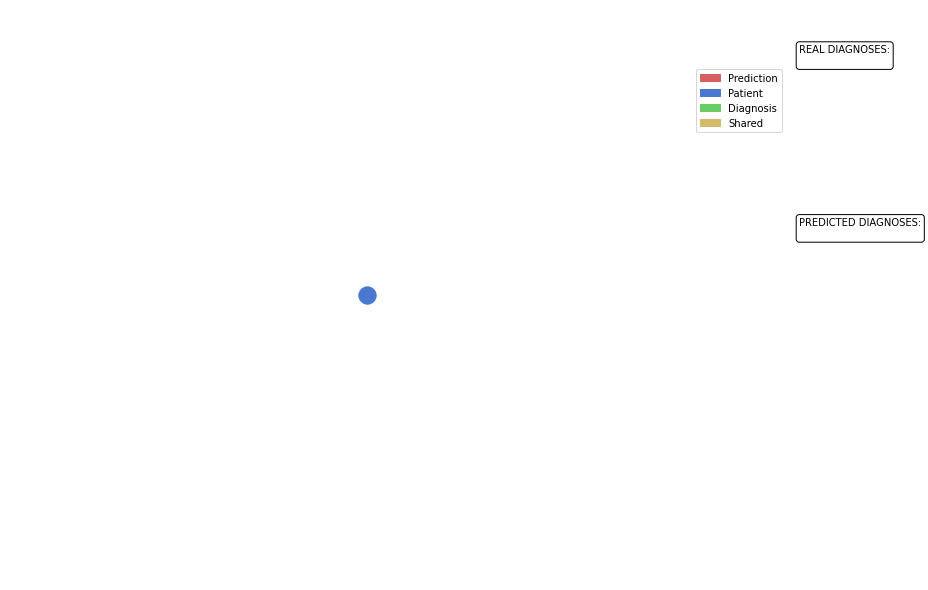

In [15]:
predictor.visualize(diagnoses, sorted_predictions, id)